# 1 - Introduction

This notebook will train a baseline linear logistic regression model. The features will be created using the bag of words technique. This means that the input will be known as a document term matrix. The document term matrix will be weighted using term frequency-inverse document (tf-idf) scaling.

The logistic regression will be regularized using the l2 norm. This means that a penalty will be applied to the l2 norm of the coefficients. This will shrink the coefficients towards 0 and each other. The use of the l2 penalty in a regression is also known as ridge regression.

The purpose of this baseline model is twofold. The first is to have benchmark model to which the decision tree and neural network mdoels can bve comapred. The second purpose is to determine the how many features should be in the document term matrix. Given these two purposes, the text lengths will not be inlcuded as a feature. The importance of the text length will be expored using decision trees.

## 1.1 - Load Packages and Global Variables

In [1]:
%matplotlib inline
from importlib import reload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from nltk import word_tokenize

In [2]:
PROJECT_DIR =os.path.join(os.getcwd(), os.pardir)
os.chdir(PROJECT_DIR)
from src.evaluation import roc_plot

## 1.2 - Load the Data

Try to load the cleaned test and train sets and complain if they are not available.

In [5]:
try:
    train = joblib.load('data/interim/train.pkl')
except FileNotFoundError:
    #if file not present, complain
    print("Train file not found, maybe you should run Notebook 1?")

In [7]:
#Load data
try:
    test = joblib.load('data/interim/test.pkl')
except FileNotFoundError:
    #if file not present, complain
    print("Train file not found, maybe you should run Notebook 1?")

# 2 - Hyperparameter Selection

The optimal regularization penalty will be determined by 10 fold cross validation. In addition to using cross-fold validation to determine the regularization strnegth, this cross validation process will be used to determine the optimal number of columns in the document term matrix, ie the number of features.

## 2.1 - Parameter Path

Before using crossfold validation to determine the optimal regularization strength and number of features, we should intelligently determine a range of values to iterate over.

### 2.1.1 - Features

As mentioned earlier, the features will be structured as a document term matrix. Document term matrices can be quite large.

The point of this exercise is not just to determine 

First, we create a data set containing numerical features that can be used in a regression. The sklearn CountVectorizer class will be used to determine the maximum number of features. Later we will use the TfidfVectorizer to do more stuff. I will use the built in word tokenizer and preprocessing in CountVectorizewr. Keep it simple. Will use 5 grams.

Will require terms to appear in at least five documents. This is kind of arbitrary but will stop spurious terms from appearing.

I will use sklearm's built in stop word list, and in addition will remove terms that appear in 80%+ of documents (kind of like dynamic stop words filteirng).

Stemming and lemmatization will not be explored. This is because recent advances in neural networks and word embeddings are  a much more efficient and elegant way of learning word relations. Neural network with word embeddings will be explored later in this project so that it why we are not putting excessive effort on transforming the words.

In [5]:
%%time
count_vec = CountVectorizer(analyzer = 'word', ngram_range = (1,3), max_df = 0.8, min_df = 5, stop_words = 'english')
count_vec.fit(train.full_text)

Wall time: 31.2 s


What are the maximum amount of terms?

In [6]:
max_features = len(count_vec.vocabulary_)
print(max_features)

231850


Let us explore a feature path of 8 blocks, increasing linearly to the maximum.

In [7]:
feature_path = np.linspace(0,max_features,9,dtype='int')[1:].tolist()
feature_path

[28981, 57962, 86943, 115925, 144906, 173887, 202868, 231850]

### 2.1.2 Regularization

For the C parameters (regularization), we will just use default of sklearn (but put in explicitly). And only do 8 instead of 10. And chop off the ends

In [8]:
cs = np.geomspace(1e-2,1e2, num = 8).tolist()
cs

[0.01,
 0.0372759372031494,
 0.13894954943731375,
 0.517947467923121,
 1.9306977288832496,
 7.196856730011514,
 26.826957952797247,
 100.0]

## 2.2 Crossfold Validation Estimates

We will use accuracy to determine the optimal set of parameters. However that will not be the only criteria. We will lean toward more regulariztion strength and less features. A reduced number of features will help prevent overfitting and reduce the amount of time it takes to train a model. Increased regulurziation strength will reduce help reduce the difference between the crossfold validation score and the test score.

In [9]:
def validate_dtm(max_terms, cpath, folds):
    tfidf = TfidfVectorizer(analyzer='word',
                            ngram_range=(1,3),
                            max_df = 0.8,
                            min_df=5,
                            max_features=max_terms,
                            stop_words = 'english')
    dtm_train = tfidf.fit_transform(train.full_text)
    vocab_len = len(tfidf.vocabulary_)
    print("DTM has {} words".format(vocab_len))
    mdl = LogisticRegressionCV(Cs = cpath, cv = folds, solver = 'lbfgs', max_iter=1250, n_jobs = 1,
                               refit = False, verbose = True, random_state = 10222017)
    mdl.fit(dtm_train, train.funny)
    test_acc = pd.DataFrame(mdl.scores_[True]).mean().values.tolist()
    test_std = pd.DataFrame(mdl.scores_[True]).std().values.tolist()
    return test_acc, test_std

In [10]:
def maxfeatures_cv(feature_path, cpath, folds = 3):
    acc = []
    std = []
    num_features = []
    num_features_indx = []
    cs = []
    cs_indx = []
    for i, max_features in enumerate (feature_path):
        print("Starting DTM {}".format(i))
        max_features = int(max_features)
        
        #get list of C values and associated indexes (lower index is lower C)
        cs.extend(cpath)
        cs_indx.extend(range(0,len(cpath)))
        
        #get list of max_features values and associated indexes, multiplied by number of C values
        num_features.extend(len(cpath) * [max_features])
        num_features_indx.extend(len(cpath) * [i])
        
        cv_acc, cv_std = validate_dtm(max_features, cpath, folds)
        std.extend(cv_std)
        acc.extend(cv_acc)
    results = pd.DataFrame({"num_features":num_features,
                            "num_features_indx":num_features_indx,
                            "accuracy":acc,
                            "StD":std,
                            "C":cs,
                            "C_indx":cs_indx})
    return results

In [11]:
%%time
results = maxfeatures_cv(feature_path, cs, folds = 8)

Starting DTM 0
DTM has 28981 words


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  9.1min finished


Starting DTM 1
DTM has 57962 words


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 12.7min finished


Starting DTM 2
DTM has 86943 words


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 15.3min finished


Starting DTM 3
DTM has 115925 words


C:\Users\wertu\Anaconda3\envs\capstone\lib\site-packages\sklearn\linear_model\logistic.py:718: UserWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number "
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 17.7min finished


Starting DTM 4
DTM has 144906 words


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 18.6min finished


Starting DTM 5
DTM has 173887 words


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 19.8min finished


Starting DTM 6
DTM has 202868 words


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 20.1min finished


Starting DTM 7
DTM has 231850 words


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 20.9min finished


Wall time: 2h 18min 28s


In [12]:
results = results.sort_values("accuracy", ascending=False)
results["one_std"] = results.accuracy - results["StD"]

In [13]:
results.head(10)

,C,C_indx,StD,accuracy,num_features,num_features_indx,one_std
60,1.930698,4,0.003270,0.679984,231850,7,0.676715
52,1.930698,4,0.003707,0.678585,202868,6,0.674877
44,1.930698,4,0.003642,0.677872,173887,5,0.674230
36,1.930698,4,0.003724,0.677099,144906,4,0.673375
59,0.517947,3,0.003996,0.676132,231850,7,0.672136
51,0.517947,3,0.004483,0.675750,202868,6,0.671268
28,1.930698,4,0.003815,0.675363,115925,3,0.671548
43,0.517947,3,0.004466,0.675140,173887,5,0.670673
35,0.517947,3,0.004347,0.674341,144906,4,0.669994
27,0.517947,3,0.004399,0.673012,115925,3,0.668613


## 3 - Evaluate Results

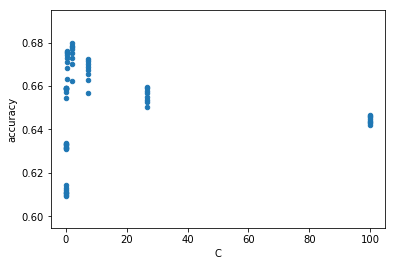

In [14]:
results.plot(x = 'C', y = 'accuracy', kind = 'scatter')

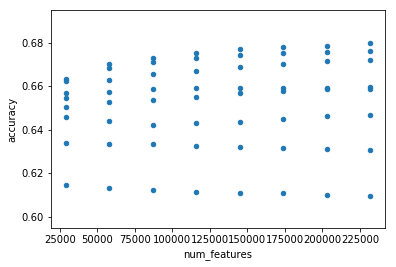

In [15]:
results.plot(x = 'num_features', y = 'accuracy', kind = 'scatter')

## Benchmark on Test

Now that we have used crossfold validation to explore the parameter space, we can train the model on the whole train data using the best set of hyperparameters. We will then evaluate the performance of the model on the test data.

In [16]:
best_C = results.iloc[0].C
max_features = results.iloc[0].num_features

In [17]:
%%time
vectorizer = TfidfVectorizer(analyzer= 'word',
                             ngram_range=(1,3),
                             max_df = 0.8,
                             min_df = 5,
                             max_features = int(max_features),
                             stop_words = 'english')
dtm = vectorizer.fit_transform(train.full_text)
mdl = LogisticRegression(C = best_C, solver = 'lbfgs', max_iter=2000) 
mdl.fit(dtm, train.funny)
test_dtm = vectorizer.transform(test.full_text)

Wall time: 56.1 s


We will first evaluate the accuracy.

In [18]:
test_acc = mdl.score(test_dtm, test.funny)
train_acc = mdl.score(dtm, train.funny)
print("Best linear model has an accuracy of {0:.2%} on the test data.".format(test_acc))
print("Best linear model has an accuracy of {0:.2%} on the train data.".format(train_acc))

Best linear model has an accuracy of 68.44% on the test data.
Best linear model has an accuracy of 80.11% on the train data.


Now that have the accuracy, let's evaluate the the performance of the model using the area under the curve. The area of the curve is our preferred metric. It works better than accuracy when with unbalanced data.

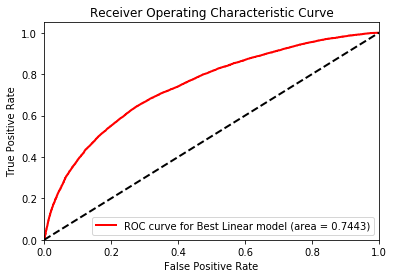

In [15]:
#test predictons
y_predicted = mdl.predict_proba(test_dtm)[:, 1]
#save test predictions
joblib.dump(y_predicted, "data/processed/linear_probs.pkl")
roc_plot(test.funny,
                    [y_predicted],
                    ["Best Linear"],
                    'reports/figures/ROC_best_linear.svg')

# 3 - Save

In [20]:
dtm_dict = {'train' : dtm,
            'test' : test_dtm,
            'vectorizer' : vectorizer}

joblib.dump(dtm_dict, 'data/processed/dtm_features.pkl')
joblib.dump(mdl, 'models/best_linear.pkl')

['models/best_linear.pkl']

In [3]:
mdl = joblib.load('models/best_linear.pkl')

In [10]:
dtm = joblib.load('data/processed/dtm_features.pkl')

In [13]:
test_dtm = dtm["test"]